In [1]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from math import ceil
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputClassifier


In [2]:
data = pd.read_csv('output/loan_dev.csv')
data = data.sort_values(by='date_loan')
data

,loan_id,date_loan,duration_loan,payments_loan,status,account_district,account_frequency,account_date,owner_district,owner_card_type,...,last_trans_balance,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_birthdate,disponent_male,disponent_birthdate
0,5314,930705,12,8033,-1,30,weekly issuance,930322,30,NaN,...,20100.0,12250.000000,5025.000000,5025.000000,NaN,5025.000000,0,470722,NaN,NaN
1,5316,930711,36,4610,1,46,monthly issuance,930213,46,NaN,...,52208.9,52083.859459,11015.635135,13523.158824,8884.240000,1411.051351,1,680722,NaN,NaN
2,6863,930728,60,2118,1,45,monthly issuance,930208,45,NaN,...,20272.8,30060.954167,5417.458333,5009.733333,6097.000000,844.708333,1,360602,NaN,NaN
3,5325,930803,36,2939,1,12,monthly issuance,930130,14,NaN,...,34307.3,41297.480000,8253.080000,9254.600000,7168.100000,1371.704000,0,400420,NaN,NaN
4,7240,930906,60,4579,1,1,weekly issuance,930214,63,NaN,...,41112.9,57188.211111,18945.966667,21255.930769,16801.000000,1522.707407,1,780907,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,961212,48,3242,1,72,monthly issuance,950121,72,NaN,...,60694.1,44197.509884,4895.974419,6448.582857,3830.458824,352.872093,0,710410,1.0,790610.0
324,5625,961215,60,3703,-1,29,monthly issuance,951129,29,NaN,...,59578.8,55230.444068,11725.494915,13417.557143,10197.180645,1009.813559,1,390320,NaN,NaN
325,6805,961221,48,938,1,70,monthly issuance,960521,70,NaN,...,38384.3,41994.907692,7779.815385,8544.930000,6974.431579,984.215385,0,570504,NaN,NaN
326,7233,961225,36,3217,1,16,monthly issuance,950520,16,NaN,...,41878.1,56646.516129,13280.084677,16554.986275,10992.139726,337.726613,1,530601,NaN,NaN


In [3]:
feat_enc = LabelEncoder()
data['account_frequency'] = feat_enc.fit_transform(data['account_frequency'])
data['owner_card_type'] = feat_enc.fit_transform(data['owner_card_type'])
data['disponent_card_type'] = feat_enc.fit_transform(data['disponent_card_type'])
data['status'] = data['status'].apply(lambda x: 0 if x == 1 else 1)

In [4]:
# These columns will be used as the inputs of the models
input_cols = [
    'duration_loan', 
    'payments_loan', 
    'account_district', 
    'account_frequency', 
    'account_date', 
    'owner_male',
    'owner_birthdate',
    'owner_district', 
    'owner_card_type', 
    #'owner_card_issued',
    #'disponent_male',
    #'disponent_birthdate',
    #'disponent_district',
    #'disponent_card_type', 
    #'disponent_card_issued', 
    'count_trans_credits',
    'count_trans_withdrawals', 
    'count_trans_credit_cash',
    'count_trans_withdrawal_cash', 
    'count_trans_withdrawal_card',
    'count_trans_collection_other_bank',
    'count_trans_remittance_other_bank',
    'count_trans_ksymbol_interest_credited',
    'count_trans_ksymbol_household',
    'count_trans_ksymbol_payment_for_statement',
    'count_trans_ksymbol_insurance_payment',
    'count_trans_ksymbol_sanction_interest_if_negative_balance',
    'count_trans_ksymbol_oldage_pension', 
    #'last_trans_balance',
    #'mean_trans_balance', 
    #'mean_trans_amount_absolute',
    #'mean_trans_amount_credit', 
    #'mean_trans_amount_withdrawal',
    #'mean_trans_amount_signed'
    ]

# The output columns are the genres
output_cols = ['status']

# Averages to calculate for precision, recall, and f1-score
averages = [None, "macro", "weighted", "micro", "samples"]

In [5]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    title,
    train_sizes, 
    train_scores, 
    test_scores, 
    fit_times,
    score_times,
    axes=None,
    ylim=None,
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    axes = axes.reshape(-1)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig = fig.delaxes(axes[-1])
    
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    # Plot n_samples vs score_times
    axes[3].grid()
    axes[3].plot(train_sizes, score_times_mean, "o-")
    axes[3].fill_between(
        train_sizes,
        score_times_mean - score_times_std,
        score_times_mean + score_times_std,
        alpha=0.1,
    )
    axes[3].set_xlabel("Training examples")
    axes[3].set_ylabel("score_times")
    axes[3].set_title("Scalability of the model")

    # Plot score_time vs score
    score_time_argsort = score_times_mean.argsort()
    score_time_sorted = score_times_mean[score_time_argsort]
    test_scores_mean_sorted = test_scores_mean[score_time_argsort]
    test_scores_std_sorted = test_scores_std[score_time_argsort]
    axes[4].grid()
    axes[4].plot(score_time_sorted, test_scores_mean_sorted, "o-")
    axes[4].fill_between(
        score_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[4].set_xlabel("score_times")
    axes[4].set_ylabel("Score")
    axes[4].set_title("Performance of the model")

    return plt



In [6]:
# The following helper functions are for training and evaluating the model

def show_confusion_matrix(cms, target_names, output_labels, title):
    """
    This helper function plots the confusion matrices calculated when evaluating the model.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    fig.suptitle(title, fontsize=32)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    gnames = ["True Negative", "False Positive", "False Negative", "True Positive"]
    gcounts = [f"{v:0.0f}" for v in cms.flatten()]
    gpercentages = [f"{v:.2%}" for v in cms.flatten()/np.sum(cms)]
    annot = np.asarray([f"{name}\n{count}\n{percentage}" for name, count, percentage in zip(gnames, gcounts, gpercentages)]).reshape(2, 2)

    sns.heatmap(cms, ax=ax, annot=annot, fmt="", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    ax.set_title("Confusion Matrix")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

def evaluate_model(model, testing_inputs, testing_classes, output_cols, sample_weight=None):
    """
    This helper function prints the report and evaluation metrics for the model.
    """
    predictions = model.predict(testing_inputs)

    print("="*70)
    print(f"Evaluation metrics for {model.__class__.__name__}")
    print("="*70)

    score = model.score(testing_inputs, testing_classes) 
    print(f"{model.__class__.__name__}'s default score metric: {score}")


    print("Classification report")
    print(
        classification_report(testing_classes, predictions, sample_weight=sample_weight, digits=4, zero_division=1)
    )

    accuracy = accuracy_score(testing_classes, predictions, sample_weight=sample_weight)
    print(f"Accuracy: {accuracy:.4f}")

    cms = confusion_matrix(testing_classes, predictions, sample_weight=sample_weight)
    show_confusion_matrix(cms, ['no', 'yes'], output_cols, f"Confusion matrices for {model.__class__.__name__}")

    print("="*70)

def train_and_evaluate(input_cols, output_cols, model, params, n_iter=None, sample_weight=None, random_state=42, scoring='accuracy'):
    """
    This function trains the model and prints the evaluation metrics, as well as the confusion matrices, and learning and scalability plots.
    """
    inputs = data[input_cols].values
    classes = data[output_cols].values
    (training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(inputs, classes, test_size=0.4, shuffle=False, random_state=random_state)

    if n_iter == None:
        clf = GridSearchCV(model, params, n_jobs=-1, cv=TimeSeriesSplit()) # TODO dont use CV mandar um iterable que da pares treino teste
    else:
       clf = RandomizedSearchCV( # TODO dont use CV
            model, params, n_iter=n_iter, scoring=scoring,
            n_jobs=-1, cv=TimeSeriesSplit(), random_state=random_state)

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        clf, training_inputs, training_classes, return_times=True, cv=5, n_jobs=-1, random_state=random_state)

    plot_learning_curve(f"Learning curves for {model.__class__.__name__}",
        train_sizes, train_scores, test_scores, fit_times, score_times)
    
    resclf = clf.fit(training_inputs, training_classes)

    plot_roc_curve(resclf, testing_inputs, testing_classes)

    if isinstance(model, DecisionTreeClassifier):
        plot_tree(resclf.best_estimator_, feature_names=input_cols)
        plt.savefig(f'output/{model.__class__.__name__}_tree_diagram.svg')
    
    print(f"Best params for {model.__class__.__name__}: {clf.best_params_}")
        
    evaluate_model(clf, testing_inputs, testing_classes, output_cols, sample_weight=sample_weight)

def use_model(model, params, scoring='accuracy', n_iter=10, random_state=42):
    """
    A more convenient wrapper around train_and_evaluate, albeit less general.
    """
    train_and_evaluate(input_cols, output_cols, model, params, n_iter=n_iter, random_state=random_state, scoring=scoring)


/home/baltazar/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Best params for DecisionTreeClassifier: {'splitter': 'best', 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 41, 'criterion': 'gini'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.8712121212121212
Classification report
              precision    recall  f1-score   support

           0     0.9153    0.9391    0.9270       115
           1     0.5000    0.4118    0.4516        17

    accuracy                         0.8712       132
   macro avg     0.7076    0.6754    0.6893       132
weighted avg     0.8618    0.8712    0.8658       132

Accuracy: 0.8712


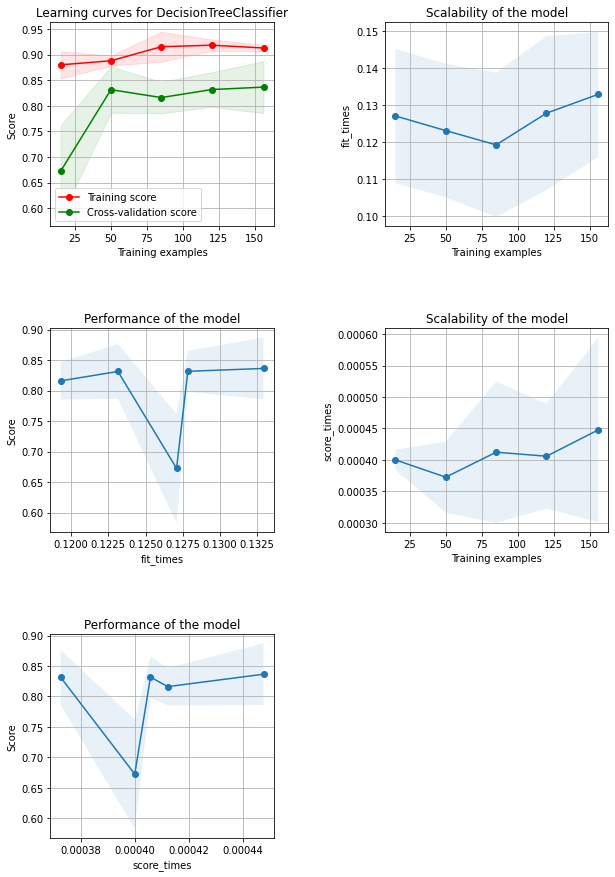

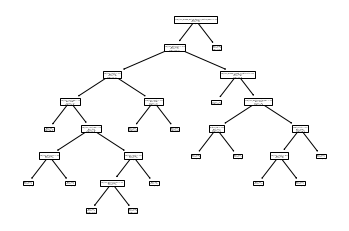

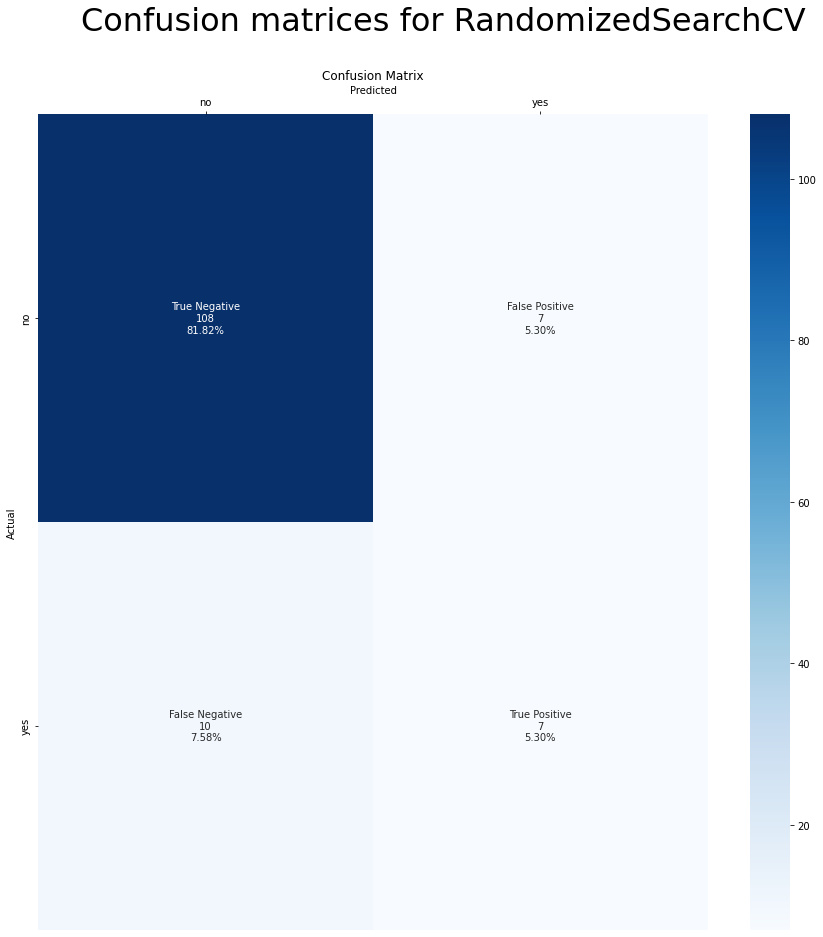

In [7]:
use_model(
    DecisionTreeClassifier(random_state=42), 
    {
        "criterion": ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        "max_depth": range(1,50),
        'max_features': range(1, len(input_cols)),
        "min_samples_split": range(2,15),
        "min_samples_leaf": range(1,7)
    }
)

/home/baltazar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConvers

Best params for RandomForestClassifier: {'n_estimators': 21, 'max_features': 5, 'max_depth': 3, 'criterion': 'gini'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.8939393939393939
Classification report
              precision    recall  f1-score   support

           0     0.8915    1.0000    0.9426       115
           1     1.0000    0.1765    0.3000        17

    accuracy                         0.8939       132
   macro avg     0.9457    0.5882    0.6213       132
weighted avg     0.9054    0.8939    0.8599       132

Accuracy: 0.8939


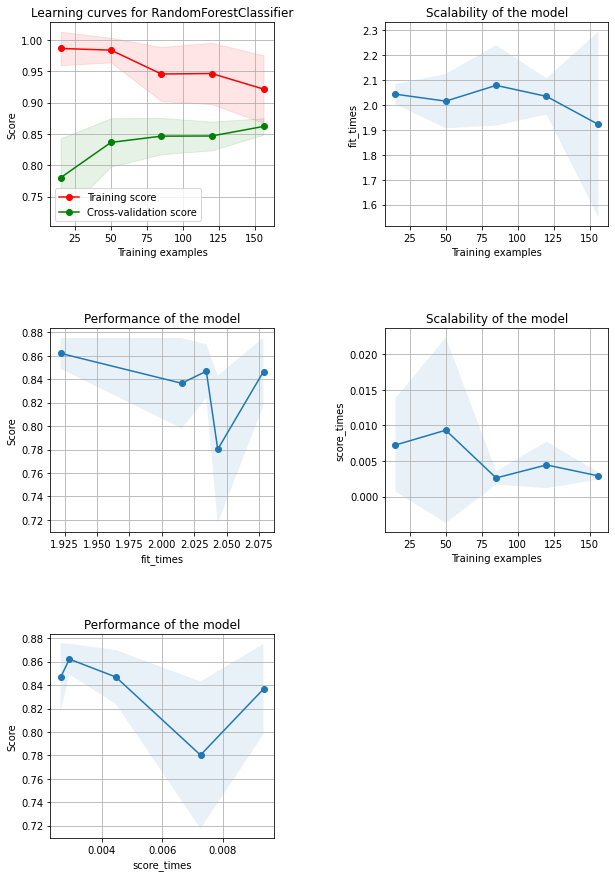

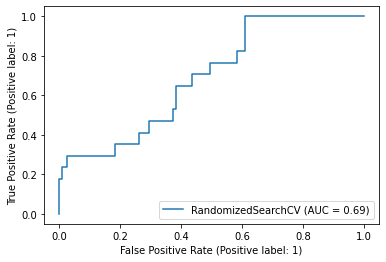

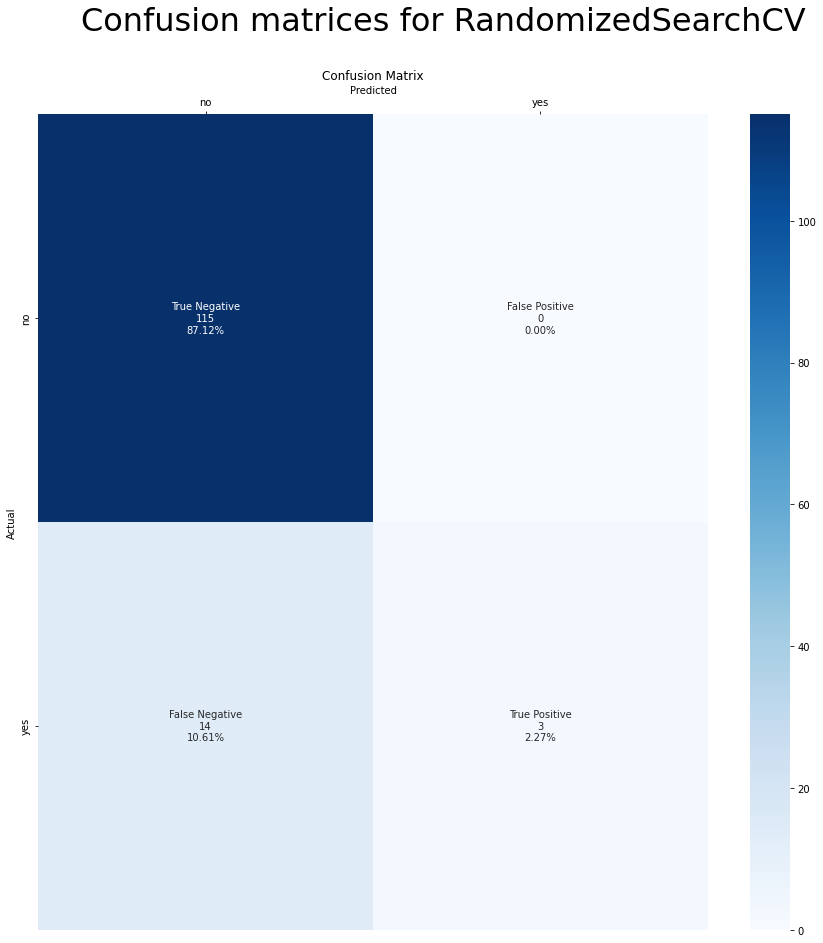

In [8]:
use_model(
    RandomForestClassifier(), 
    { 
        'n_estimators': range(5, 30),
        'max_features': range(1, 8),
        "max_depth": range(1,15),
        'criterion' :['gini', 'entropy']
    }
)

/home/baltazar/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Best params for KNeighborsClassifier: {'weights': 'uniform', 'n_neighbors': 19}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.8712121212121212
Classification report
              precision    recall  f1-score   support

           0     0.8712    1.0000    0.9312       115
           1     1.0000    0.0000    0.0000        17

    accuracy                         0.8712       132
   macro avg     0.9356    0.5000    0.4656       132
weighted avg     0.8878    0.8712    0.8113       132

Accuracy: 0.8712


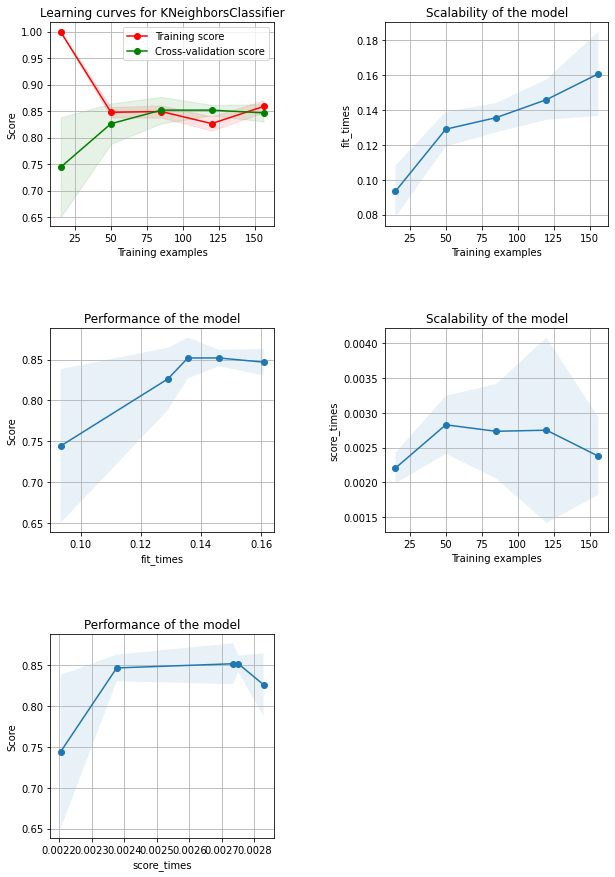

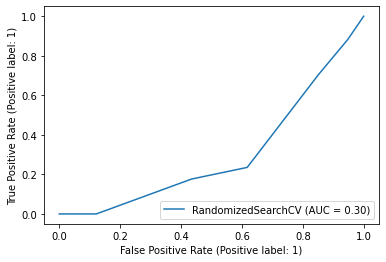

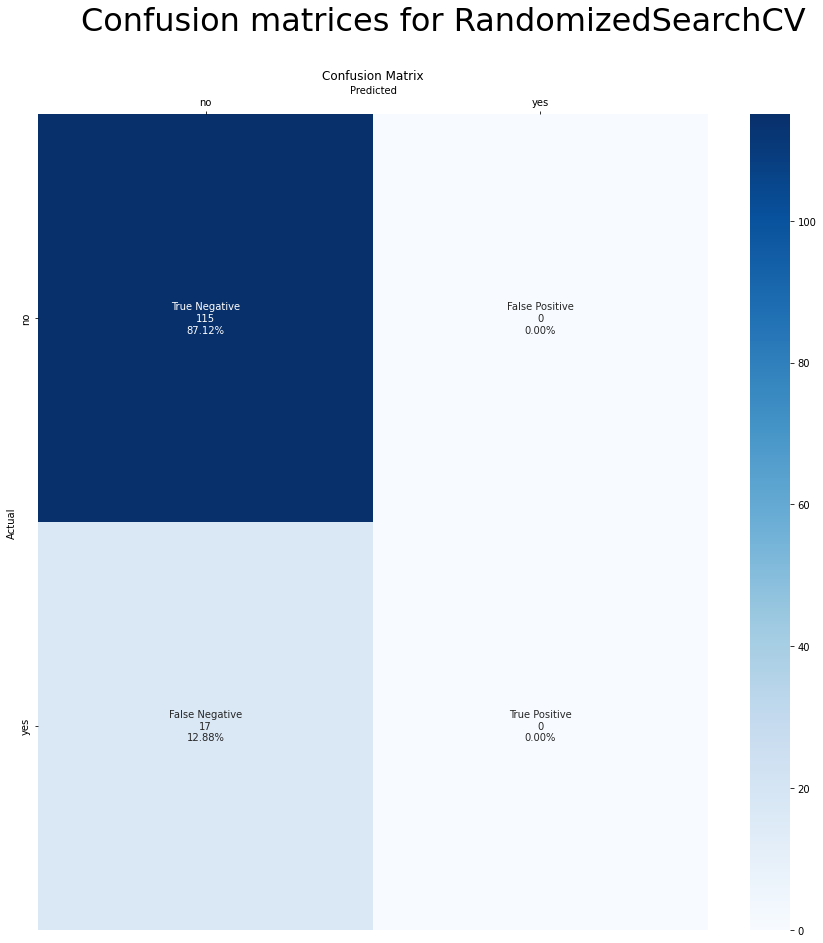

In [9]:
use_model(
    KNeighborsClassifier(), 
    {
        "n_neighbors": list(range(1,31)),
        "weights": ['uniform', 'distance'],
    }
)

In [13]:
use_model(
    SVC(), 
    {
        'C': [0.1, 1, 10, 100],
        'gamma': [1,0.1,0.01,0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    n_iter=3
)

/home/baltazar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/baltazar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [11]:
use_model(
    GaussianNB(), 
    {
        'var_smoothing': np.logspace(0,-9, num=100)
    },
)

TypeError: use_model() got an unexpected keyword argument 'multi_output'

In [ ]:
use_model(
    GradientBoostingClassifier(),
    {
        'max_features': range(7,20,2),
        'min_samples_split':range(1000,2100,200),
        'min_samples_leaf':range(30,71,10),
        'max_depth':range(5,16,2),
        'min_samples_split':range(200,1001,200)
    },
)

In [ ]:
use_model(
    AdaBoostClassifier(),
    {
        'n_estimators': [10,50,100,500],
        'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]
    },
    multi_output=True
)